In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [7]:
from tqdm import tqdm

Напишем свой автокодировщик

# ***MY AE***

In [8]:
class MY_ENCODER(nn.Module):
  def __init__(self, latent_dims):
    super(MY_ENCODER, self).__init__()
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2),
        nn.BatchNorm2d(8),
        nn.PReLU(),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
        nn.BatchNorm2d(16),
        nn.PReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2),
        nn.BatchNorm2d(32),
        nn.PReLU()
    )

    self.encoder_fc = nn.Sequential(
        nn.Linear(800, latent_dims),
        nn.PReLU(),
    )


  def forward(self, x):
    x = self.encoder_cnn(x)
    x = torch.flatten(x, start_dim=1)
    x = self.encoder_fc(x)
    return x

In [9]:
class MY_DECODER(nn.Module):
  def __init__(self, latent_dims):
    super(MY_DECODER, self).__init__()

    self.decoder_fc = nn.Sequential(
        nn.Linear(latent_dims, 32*8*8),
        nn.PReLU(),
    )

    self.unflatten = nn.Unflatten(1, (32,8,8))

    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
        nn.BatchNorm2d(16),
        nn.PReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
        nn.BatchNorm2d(8),
        nn.PReLU(),
        nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2),
        nn.BatchNorm2d(3),
        nn.PReLU()
    )

    self.decoder_fc2 = nn.Sequential(
        nn.Linear(3*71*71, 3*64*64),
        nn.PReLU(),
    )


  def forward(self, x):
    x = self.decoder_fc(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.flatten(x, start_dim=1)
    x = self.decoder_fc2(x)
    x = torch.sigmoid(x)
    return x.reshape((-1,3,64,64))

In [10]:
class MY_AUTOENCODER(nn.Module):
  def __init__(self, latent_dims):
    super(MY_AUTOENCODER, self).__init__()
    self.encoder = MY_ENCODER(latent_dims)
    self.decoder = MY_DECODER(latent_dims)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

# AE Training

уменьшим кол-во эпох до 5

In [11]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder.forward(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

# Date Loading

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
latent_dims = 512

data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Vae/custom_cartoons',
               transform=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()]),
        ),
        batch_size=32,
        shuffle=True)



In [14]:
dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Vae/custom_cartoons',
               transform=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()]),
        ),

In [15]:
next(iter(data))

[tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],
 
 
         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1

In [ ]:
my_autoencoder = MY_AUTOENCODER(latent_dims).to(device)
my_autoencoder = train(my_autoencoder, data)

100%|██████████| 20/20 [23:38<00:00, 70.92s/it]


In [17]:
z = torch.rand((1, 512)).to(device)

In [18]:
res = my_autoencoder.decoder(z)

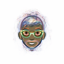

In [ ]:
res = my_autoencoder.decoder(z)
torchvision.transforms.ToPILImage()(res[0])

# VAE

In [ ]:
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
class My_VariationalEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(My_VariationalEncoder, self).__init__()
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2),
        nn.BatchNorm2d(8),
        nn.PReLU(),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
        nn.BatchNorm2d(16),
        nn.PReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2),
        nn.BatchNorm2d(32),
        nn.PReLU()
    )

    self.encoder_fc1 = nn.Sequential( #mu
        nn.Linear(800, latent_dims),
        nn.PReLU(),
    )

    self.encoder_fc2 = nn.Sequential( #sigma
        nn.Linear(800, latent_dims),
        nn.PReLU(),
    )

    self.N = torch.distributions.Normal(0, 1) # psi
    self.kl = 0 # kld

  def forward(self, x):
    #x = torch.flatten(x, start_dim=1)
    #x = F.relu(self.linear1(x))
    x = self.encoder_cnn(x)
    x = torch.flatten(x, start_dim=1)
    mu =  self.encoder_fc1(x)
    sigma = (torch.exp(self.encoder_fc2(x)))
    z = mu + sigma * self.N.sample(mu.shape).to(device)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z

In [ ]:
class MY_VAE(torch.nn.Module):
  def __init__(self, latent_dims):
    super(MY_VAE, self).__init__()
    self.encoder = My_VariationalEncoder(latent_dims)
    self.decoder = MY_DECODER(latent_dims)

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

In [ ]:
vae = MY_VAE(latent_dims).to(device) # GPU
vae = train_vae(vae, data)


100%|██████████| 20/20 [23:42<00:00, 71.11s/it]


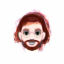

In [ ]:
res = vae.decoder(z)
torchvision.transforms.ToPILImage()(res[0])

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    z = z.squeeze(1).to(device)
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        #print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = next(data.__iter__())
x_1 = x[0].unsqueeze(0).to(device)
x_2 = x[1].unsqueeze(0).to(device)

# Compare AE and VAE Interpolations
- Which is better?
- Why?
- Ответ буду читац глазами, лучше подкрепить картинками и объяснениями

Автокодировщик и вариационный автокодировщик, написанные с помощью сверточной НС работают очевидно лучше исходного на полносвязной НС, это видно при интерполяции изображений - лучше качество изображений и больше вариаций изображений

Если сравнивать AE И VAE, то разница заметна в насыщенности цветов изображений, VAE генерирует более интересные изображения. Это связано с тем, что в латентном представлении VAE не имеет дыр, т.е. пространство является непрерывным, поэтому интерполяция получается более вариативная


AE

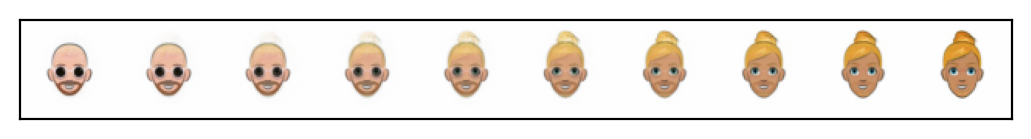

In [ ]:
interpolate(my_autoencoder, x_1, x_2, n=10)

VAE

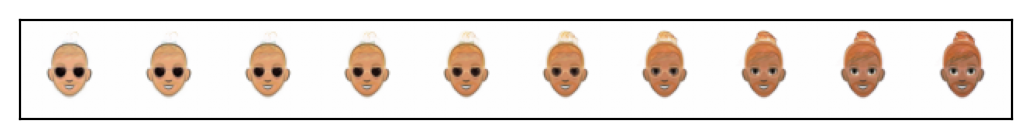

In [ ]:
interpolate(vae, x_1, x_2, n=10)
